<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#CatBoortRegressor" data-toc-modified-id="CatBoortRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoortRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем библиотеки, которые понадобятся при выполнении проекта

In [1]:
import pandas as pd
import numpy as np
import warnings

from numpy.random import RandomState

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error #mean_absolute_error

from statsmodels.tsa.stattools import adfuller

Загрузим файл с данными

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Отсортируем индексы таблицы и проверим, в хронологическом ли порядке расположены даты и время.

In [4]:
data = data.sort_index()
print(data.index.is_monotonic)
print(data.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Проведем ресемплирование, сделаем промежуток в 1час и определим количество заказов на каждый час.

In [5]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Построим график 

<AxesSubplot:title={'center':'Количество заказов такси'}, xlabel='datetime'>

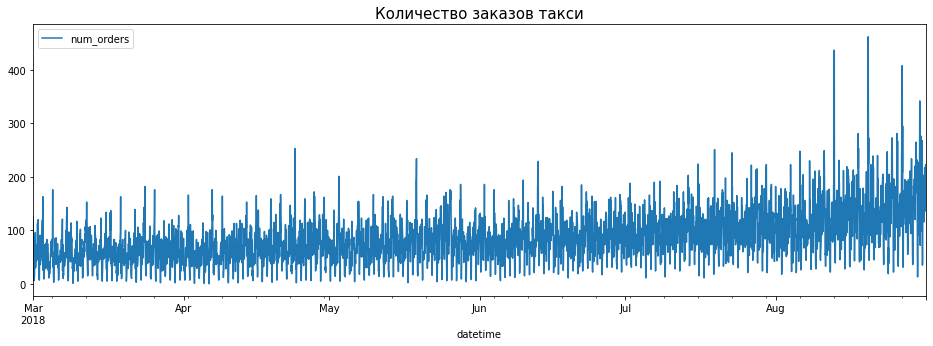

In [6]:
plt.figure(figsize=(16,5))
plt.title('Количество заказов такси', fontsize=15)
plt.xlabel('Время', fontsize=10)
data.plot(ax=plt.gca())

**Вывод:**<br>
Мы загрузили данные и значения столбца 'datetime' сделали индексами датасета.<br>
Провели Ресемплирование и определили количество заказов на каждый час.

## Анализ

Найдем скользящее среднее с размером окна в неделю и добавим столбец 'rolling_mean' в датасет.

<AxesSubplot:title={'center':'Количество заказов такси со скользящием средним'}, xlabel='datetime'>

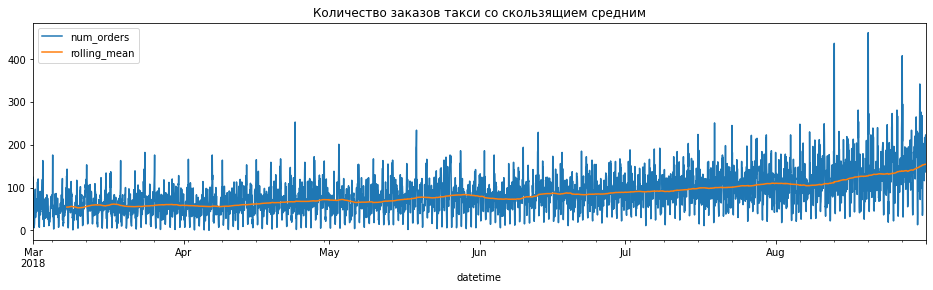

In [7]:
data['rolling_mean'] = data.rolling(24*7).mean()
plt.figure(figsize=(16,4))
plt.title('Количество заказов такси со скользящием средним')
data.plot(ax=plt.gca())

<div class="alert alert-info"> <b>ℹ️ Комментарий студента: </b> Тест Дики-Фуллера </div>

In [8]:
st_test = adfuller(data['num_orders'], regression='ctt')
st_test

(-10.891452237749158,
 4.0549397892403547e-17,
 31,
 4384,
 {'1%': -4.373775161444573,
  '5%': -3.8337377543683258,
  '10%': -3.554095038926073},
 41625.74040564322)

In [9]:
test = adfuller(data['num_orders'], regression='ctt')
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -10.891452237749158
p-value:  4.0549397892403547e-17
Critical values:  {'1%': -4.373775161444573, '5%': -3.8337377543683258, '10%': -3.554095038926073}
единичных корней нет, ряд стационарен


<div class="alert alert-info"> <b>ℹ️ Комментарий студента: </b> Провел тест Дики-Фулера. И да, несмотря на то что имеется тренд на увеличение и среднее значение тоже увеличивается, временый ряд является стационарным. </div>

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Дополнительно можно проверить стационарность ряда с помощью критерия Дики-Фуллера.
    
    from statsmodels.tsa.stattools import adfuller

    st_test = adfuller(taxi['num_orders'], regression='ctt')
    
Здесь выбрали параметр 'ctt' — т.е. в данных наблюдается константа, линейный и квадратичный тренд.
   
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
    
https://habr.com/ru/post/207160/
    
</div>

Проведем декомпозицию и разложим временной ряд на три составляющие: тренд, сезонность и остаток.

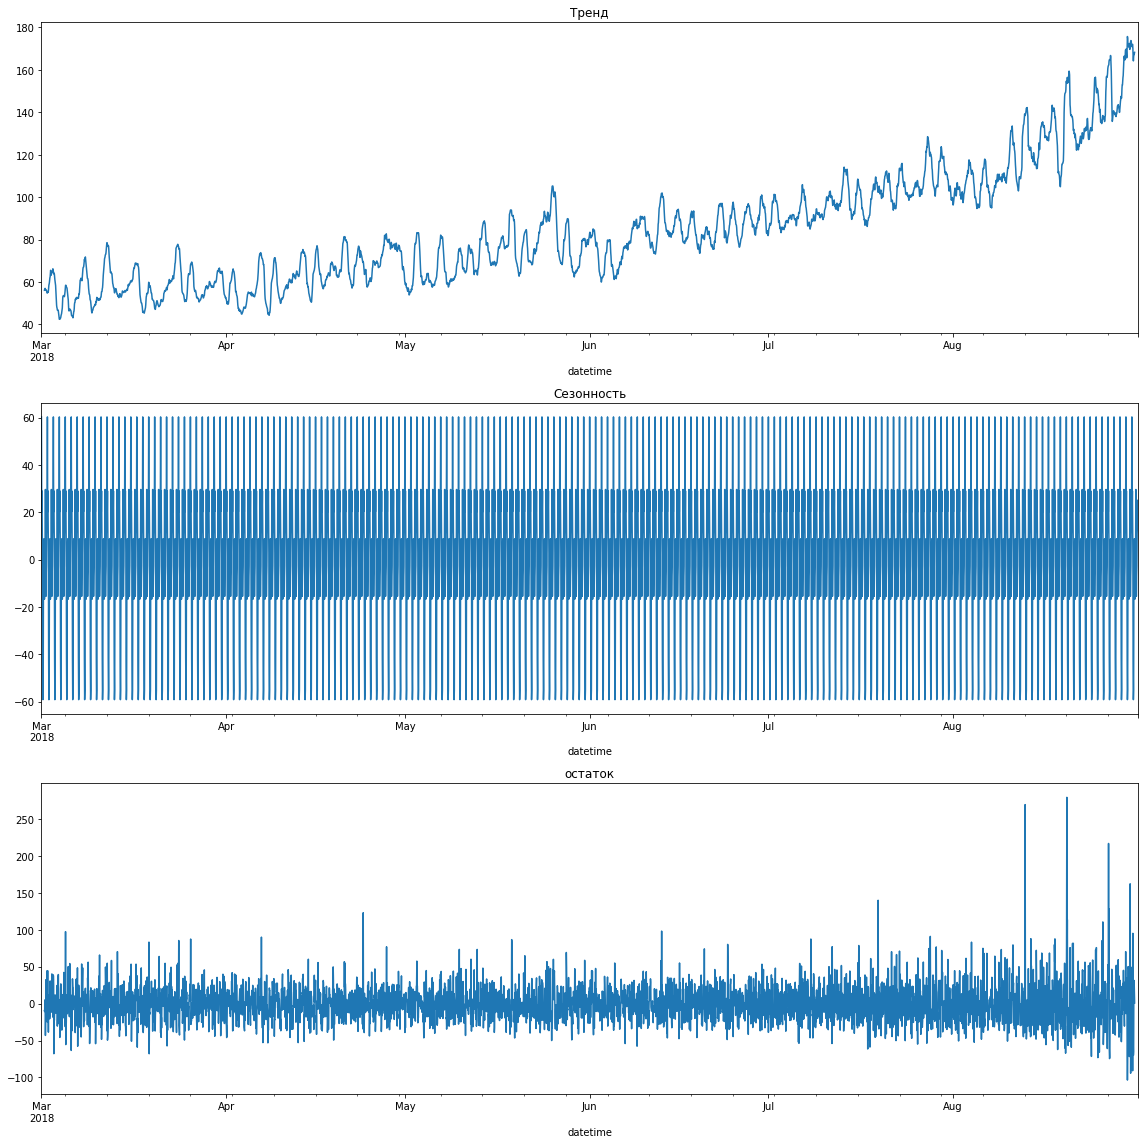

In [10]:
decomposed = seasonal_decompose(data.drop(['rolling_mean'], axis = 1))

plt.figure(figsize=(16, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('остаток')
plt.tight_layout()

В течении полугода тренд увеличивается.

Рассмотрим сезонность заказов за два дня и в течении суток.

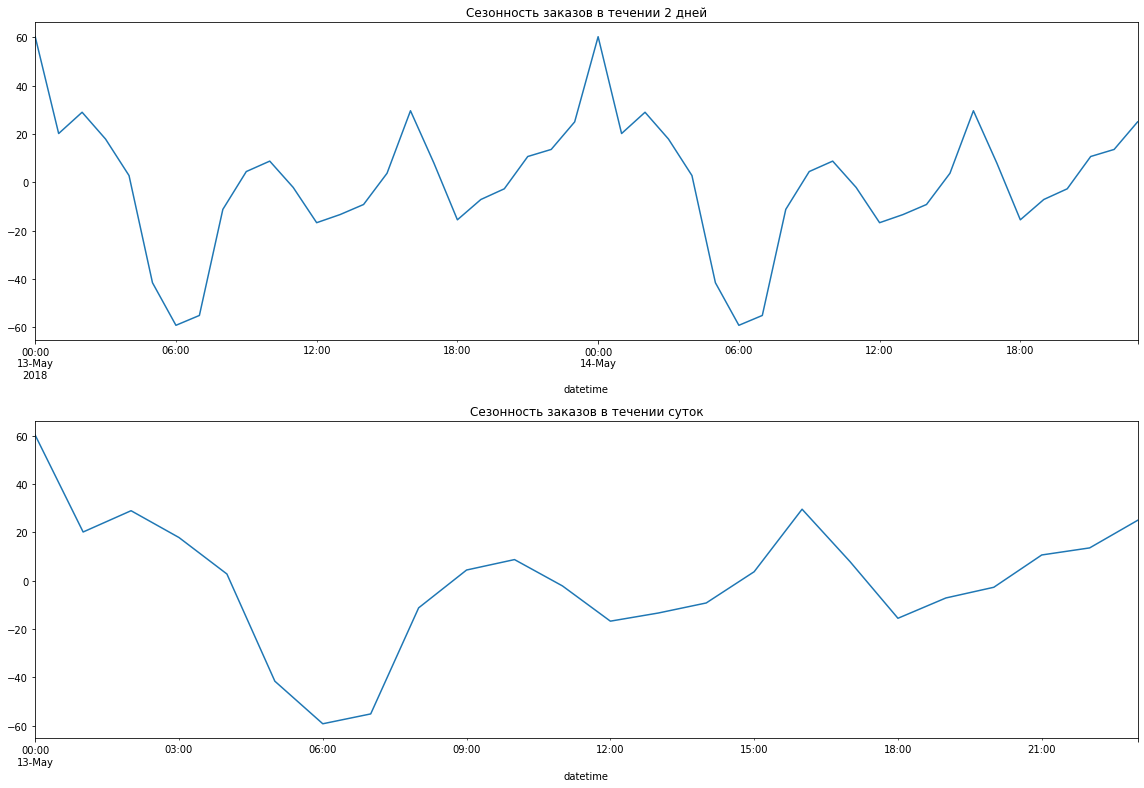

In [11]:
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title("Сезонность заказов в течении 2 дней")
decomposed.seasonal['2018-05-13':'2018-05-14'].plot(ax=plt.gca())
plt.subplot(312)
plt.title("Сезонность заказов в течении суток")
decomposed.seasonal['2018-05-13':'2018-05-13'].plot(ax=plt.gca())
plt.tight_layout()

**Вывод:**<br>
Общий тренд за пол года направлен на увеличение.<br>
Максимальное количество заказов приходится на 00:00 часов, а минимальное количество в 06:00 часов. Резко увеличивается количество заказов примерно с 07:30 и ростет до 10:00, затем плавно снижается к 12:00 и плавно увеличиваетс к 16:00. С 16 часов до 18 наблюдается спад, а с 18:00 увеличивается спрос до 00:00.

## Обучение

Создадим признаки. Напишим функциюдля создания признаков. Разберём каждый тип признаков на:
1. Календарные признаки;
2. «Отстающие значения»;
3. Скользящее среднее.<br>

И удалим пропущенные значения.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
#    data['year'] = data.index.year
#    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [13]:
make_features(data, 24, 7)

In [14]:
data = data.dropna()
data.head()

,num_orders,rolling_mean,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,65.714286,2,4,0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 01:00:00,120,72.285714,2,4,1,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 02:00:00,75,79.000000,2,4,2,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 03:00:00,64,83.285714,2,4,3,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 04:00:00,20,83.714286,2,4,4,64.0,75.0,120.0,90.0,58.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   rolling_mean  4392 non-null   float64
 2   day           4392 non-null   int64  
 3   dayofweek     4392 non-null   int64  
 4   hour          4392 non-null   int64  
 5   lag_1         4392 non-null   float64
 6   lag_2         4392 non-null   float64
 7   lag_3         4392 non-null   float64
 8   lag_4         4392 non-null   float64
 9   lag_5         4392 non-null   float64
 10  lag_6         4392 non-null   float64
 11  lag_7         4392 non-null   float64
 12  lag_8         4392 non-null   float64
 13  lag_9         4392 non-null   float64
 14  lag_10        4392 non-null   float64
 15  lag_11        4392 non-null   float64
 16  lag_12        4392 non-null   float64
 17  lag_13        4392 non-null

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Следует отметить, что параметры авторегрессии и скользящего среднего можно выбирать графически:
    
Чтобы оценить порядок авторегрессии, можно построить график частной автокорреляционной функции plot_pacf()
    
А для того, чтобы оценить порядок скользящего среднего, построить график автокорреляционной функции plot_acf(). 
    
Нам нужен тот параметр, после которого значения функции равны или близки нулю.
    
Подходить может много вариантов, но выбор слишком больших параметров усложнит модель

    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

    plot_pacf(data, alpha=None).set_size_inches(12, 4)
    plt.show()

    plot_acf(data, alpha=None).set_size_inches(12, 4)
    plt.show()

</div>

Разобьем датасет на обучающую и тестовую выборки и выделим признаки.

In [16]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [17]:
features_train=train.drop (['num_orders'], axis = 1)
target_train=train['num_orders']
features_test=test.drop (['num_orders'], axis = 1)
target_test=test['num_orders']

In [18]:
print(features_train.shape)
print(features_test.shape)

(3952, 28)
(440, 28)


In [19]:
def params_grid(model,params,scoring,features,target):
    '''
    Input: model - обучаемая модель, params - набор параметров модели, scoring -метрика оценки ошибки,
           features,target - признаки и целевой признак обучающей выборки.
    Output: model_grid,best_params,best_score - модель, ее лучшие параметры и 
            наименьшее значение метрики оценки ошибки
    Description: Функция ищет лучшие параметры из диапазона переданного в аргумент, 
                 для принимаемой в аргумент модели

    '''
    model_grid = GridSearchCV(model,params,cv=5, n_jobs=-1,scoring=scoring, verbose=2)
    model_grid.fit(features,target)
    best_params = model_grid.best_params_
    best_score = model_grid.best_score_
    return model_grid,best_params,best_score

### LinearRegression

<b>Про кросс-валидацию временных рядов:</b> (дополнительные материалы)\
В случае с временным рядом нам нужно задать кросс-валидацию TimeSeriesSplit\
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html \
Если мы исследуем временной ряд, то в каждом сплите тестовые индексы должны быть позже по времени, чем обучающие, поэтому перетасовка обычным способом неуместна. Как раз TimeSeriesSplit решает эту проблему.\
Иллюстрация работы:\
</font>
![image.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png)

Код реализации:
```python
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search)
gsearch.fit(X, y)
```

<div class="alert alert-info"> <b>ℹ️ Комментарий студента: </b> Попробовал сделать ОНЕ функцией get_dummies() для features_train и features_test, но у выборок получается разный размер с разницей в 12 признаков. </div>

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера v2:</b> Все, я понял в чем проблема — на тестовой выборке не все дни месяца представлены, поэтому так. Чтобы все закодировалось правильно, нужно применить OneHotEncoder
    
</div>

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера v2:</b> Нужно установить актуальную версию библиотеки scikit-learn и проверить что установилась нужная версия:

    !pip install scikit-learn==1.1.3
    import sklearn
    sklearn.__version__

Пример с OneHotEncoder:    
    
    # создаем список категориальных колонок cat_columns и числовых numeric
    
    ohe_enc = OneHotEncoder(drop = 'first', handle_unknown='ignore')
    ohe_enc.fit(X_train[cat_columns])
    new_columns = ohe_enc.get_feature_names(cat_columns)
    X_train_ohe = pd.DataFrame(ohe_enc.transform(X_train[cat_columns]).toarray(), 
                                columns = new_columns, index = X_train.index)
    X_train_ohe = X_train.ohe.join(X_train[numeric]) # объединяем таблицы
   
    
</div>

In [20]:
model_LinReg = LinearRegression()
rmse_LinReg = cross_val_score(model_LinReg, features_train, target_train,
                                          cv=5, scoring='neg_root_mean_squared_error').min()
rmse_LinReg = rmse_LinReg *(-1)
print('RMSE линейной регрессии кросвалидацией', rmse_LinReg)

RMSE линейной регрессии кросвалидацией 33.19165945910158


In [21]:
features_train_ohe = pd.get_dummies(features_train, columns=['day', 'dayofweek', 'hour'], drop_first=True)
features_test_ohe = pd.get_dummies(features_test, columns=['day', 'dayofweek', 'hour'], drop_first=True)
print(features_train_ohe.shape)
print(features_test_ohe.shape)

(3952, 84)
(440, 72)


In [22]:
#model_LinReg = LinearRegression()
#model_LinReg.fit(features_train, target_train) 
#predicted_LinReg = model_LinReg.predict(features_train)
#rmse_LinReg = mean_squared_error(target_train, predicted_LinReg) ** 0.5 
#
#print('RMSE линейной регрессии', rmse_LinReg)

### DecisionTreeRegressor

In [23]:
model_tree = DecisionTreeRegressor(random_state=12345)
rmse_tree = cross_val_score(model_tree, features_train, target_train,
                                          cv=5, scoring='neg_root_mean_squared_error').min()
rmse_tree = rmse_tree *(-1)
print('RMSE решающего дерева кросвалидацией', rmse_tree)

RMSE решающего дерева кросвалидацией 45.708584352879534


In [24]:
params_tree = {'max_depth': range(5,8,1)}
model_tree = DecisionTreeRegressor(random_state=12345)

In [25]:
tree_grid = params_grid(model_tree,params_tree,'neg_root_mean_squared_error',features_train,target_train)
tree_grid

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=6; total time=   0.0s
[CV] END ........................................max_depth=6; total time=   0.0s
[CV] END ........................................max_depth=6; total time=   0.0s
[CV] END ........................................max_depth=6; total time=   0.0s
[CV] END ........................................max_depth=6; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................

(GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
              n_jobs=-1, param_grid={'max_depth': range(5, 8)},
              scoring='neg_root_mean_squared_error', verbose=2),
 {'max_depth': 5},
 -27.915350746714587)

### CatBoortRegressor

In [26]:
model_cat = CatBoostRegressor(learning_rate = 0.2, random_state=12345)
rmse_cat = cross_val_score(model_cat, features_train, target_train,
                                          cv=5, scoring='neg_root_mean_squared_error').min()
rmse_cat = rmse_cat *(-1)
print('RMSE CatBoortRegressor кросвалидацией', rmse_cat)

0:	learn: 35.6585722	total: 54.7ms	remaining: 54.6s
1:	learn: 33.0560272	total: 60.5ms	remaining: 30.2s
2:	learn: 31.2103453	total: 66.1ms	remaining: 22s
3:	learn: 29.7659874	total: 71.8ms	remaining: 17.9s
4:	learn: 28.4841021	total: 77ms	remaining: 15.3s
5:	learn: 27.4062675	total: 82.4ms	remaining: 13.7s
6:	learn: 26.5164697	total: 87.7ms	remaining: 12.4s
7:	learn: 26.0261177	total: 93ms	remaining: 11.5s
8:	learn: 25.4806035	total: 97.9ms	remaining: 10.8s
9:	learn: 24.9105041	total: 103ms	remaining: 10.2s
10:	learn: 24.5854754	total: 108ms	remaining: 9.7s
11:	learn: 24.5353531	total: 109ms	remaining: 9s
12:	learn: 24.3900951	total: 114ms	remaining: 8.65s
13:	learn: 24.1175380	total: 119ms	remaining: 8.38s
14:	learn: 23.8417639	total: 124ms	remaining: 8.15s
15:	learn: 23.5636031	total: 129ms	remaining: 7.95s
16:	learn: 23.5103673	total: 134ms	remaining: 7.74s
17:	learn: 23.4210502	total: 139ms	remaining: 7.56s
18:	learn: 23.3928831	total: 143ms	remaining: 7.41s
19:	learn: 23.2317819	t

In [27]:
params_cat = {'depth': range(7, 9, 1), 'iterations': range(28, 30, 1)}
model_cat = CatBoostRegressor(learning_rate = 0.2, random_state=12345)

In [28]:
cat_grid = params_grid(model_cat,params_cat,'neg_root_mean_squared_error',features_train,target_train)
cat_grid

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 35.5246466	total: 13.8ms	remaining: 373ms
1:	learn: 32.8618979	total: 22.9ms	remaining: 298ms
2:	learn: 30.8256076	total: 32ms	remaining: 266ms
3:	learn: 29.1240303	total: 40.7ms	remaining: 244ms
4:	learn: 27.8907016	total: 49.4ms	remaining: 227ms
5:	learn: 26.9453077	total: 57.8ms	remaining: 212ms
6:	learn: 26.1969941	total: 66.5ms	remaining: 199ms
7:	learn: 25.5774789	total: 74.7ms	remaining: 187ms
8:	learn: 25.0474949	total: 83.1ms	remaining: 175ms
9:	learn: 24.6318932	total: 92ms	remaining: 166ms
10:	learn: 24.3326784	total: 100ms	remaining: 155ms
11:	learn: 24.0257712	total: 110ms	remaining: 147ms
12:	learn: 23.7031692	total: 118ms	remaining: 137ms
13:	learn: 23.4432044	total: 127ms	remaining: 127ms
14:	learn: 23.1831924	total: 136ms	remaining: 118ms
15:	learn: 23.1395440	total: 145ms	remaining: 109ms
16:	learn: 22.8737379	total: 153ms	remaining: 99.2ms
17:	learn: 22.6147611	total: 161ms	remaining: 89.7ms
18:	le

(GridSearchCV(cv=5,
              estimator=<catboost.core.CatBoostRegressor object at 0x7fd6ab2e7220>,
              n_jobs=-1,
              param_grid={'depth': range(7, 9), 'iterations': range(28, 30)},
              scoring='neg_root_mean_squared_error', verbose=2),
 {'depth': 8, 'iterations': 29},
 -24.11861635898539)

### LightGBM 

In [29]:
#model_LGBM = LGBMRegressor(learning_rate=0.2, metric='rmse', random_state=12345, verbose=10)
#rmse_LGBM = cross_val_score(model_LGBM, features_train, target_train,
#                                          cv=5, scoring='neg_root_mean_squared_error').min()
#rmse_LGBM = rmse_LGBM *(-1)
#print('RMSE модели LightGBM найденое кросвалидацией', rmse_LGBM)

In [30]:
params_LGBM = {'n_estimators': range(13,15,1), 'max_depth': range(3,5,1)}
model_LGBM = LGBMRegressor(random_state=12345, learning_rate=0.2, verbose=10)

In [31]:
LGBM_grid = params_grid(model_LGBM,params_LGBM,'neg_root_mean_squared_error',features_train,target_train)
LGBM_grid

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.006824
[LightGBM] [Debug] init for col-wise cost 0.089865 seconds, init for row-wise cost 0.101308 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4798
[LightGBM] [Info] Number of data points in the train set: 3161, number of used features: 28
[LightGBM] [Info] Start training from score 83.798481
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree 

(GridSearchCV(cv=5,
              estimator=LGBMRegressor(learning_rate=0.2, random_state=12345,
                                      verbose=10),
              n_jobs=-1,
              param_grid={'max_depth': range(3, 5),
                          'n_estimators': range(13, 15)},
              scoring='neg_root_mean_squared_error', verbose=2),
 {'max_depth': 4, 'n_estimators': 14},
 -24.603212575468653)

**Вывод:**<br>

По итогам оценки качества моделей получили следующие значения:

| Модели |    RMSE cross_val |    RMSE GridSearch   |
| :--- | :----------- | :----------|
| LinearRegression | 33.19 | - |
| DecisionTreeRegressor | 45.71 | 27.92 |
| CatBoortRegressor | 32.77 | 24.11 |
| LGBMRegressor     | - | 24.60 |

Итоговой моделью с самым лучшим качеством при оценке кросс-валидацией принимаем CatBoortRegressor

## Тестирование

Напишим функцию, которая принимает модель с параметрами и возвращает RMSE тестовой выборки.

In [32]:
def test_model(model):
    
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    
    rmse = mean_squared_error(target_test, predictions)**0.5

    return rmse

In [33]:
#test_model(LinearRegression())

In [34]:
#test_model(DecisionTreeRegressor(random_state=12345, max_depth=6))

In [35]:
test_model(CatBoostRegressor(learning_rate = 0.2, random_state=12345, depth=8, iterations=29))

0:	learn: 35.1308162	total: 30.4ms	remaining: 850ms
1:	learn: 32.1580909	total: 48.9ms	remaining: 660ms
2:	learn: 29.9295517	total: 64.8ms	remaining: 561ms
3:	learn: 28.0589995	total: 80.4ms	remaining: 503ms
4:	learn: 26.8474949	total: 95.9ms	remaining: 460ms
5:	learn: 25.9217264	total: 112ms	remaining: 428ms
6:	learn: 24.9470287	total: 128ms	remaining: 402ms
7:	learn: 24.1930406	total: 144ms	remaining: 377ms
8:	learn: 23.6251425	total: 160ms	remaining: 355ms
9:	learn: 23.1164270	total: 176ms	remaining: 334ms
10:	learn: 22.6659526	total: 192ms	remaining: 314ms
11:	learn: 22.3458527	total: 208ms	remaining: 294ms
12:	learn: 21.9970014	total: 224ms	remaining: 276ms
13:	learn: 21.7536275	total: 241ms	remaining: 258ms
14:	learn: 21.6992837	total: 257ms	remaining: 240ms
15:	learn: 21.6628035	total: 273ms	remaining: 222ms
16:	learn: 21.4772732	total: 289ms	remaining: 204ms
17:	learn: 21.3663267	total: 306ms	remaining: 187ms
18:	learn: 21.2485634	total: 322ms	remaining: 169ms
19:	learn: 20.941

46.99183144456853

In [36]:
#test_model(LGBMRegressor(random_state=12345, learning_rate=0.2, verbose=10, max_depth=4, n_estimators=14))

**Вывод:**<br>
По итогам оценки качества моделей получили следующие значения:

| Модели |    RMSE cross_val |    RMSE GridSearch   | RMSE тестовой выборки |
| :--- | :----------- | :----------| :----------|
| LinearRegression | 33.19 | - | - |
| DecisionTreeRegressor | 45.71 | 27.92 | - |
| CatBoortRegressor | 32.77 | 24.11 | 46.99 |
| LGBMRegressor     | - | 24.60 | - |

**Общий вывод:**<br>
При проверке качества предсказаний на тестовой выборке модель CatBoortRegressor, показала заданный результат, менее 48. Эту модель можно использовать для пердсказания количества заказов на следующий час.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48